# SiPM Showers

#### 1) Select events using a run's DST file -- > 2) Look at those events' waveforms

Here, I use this notebook to look at the waveforms of sodium events near the photoelectric peak

In [1]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-26 17:30:44


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import time
import tables as tb
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from invisible_cities.database import load_db
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.params import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units
from invisible_cities.core.core_functions import in_range
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.reco.pmaps_functions import plot_s12

sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
from icaro.core.event_pmaps     import EventPmaps, print_s12, print_s2si
from icaro.core.kdst_functions  import load_dst, event_rate, profile_and_fit, print_fit, chi2
from icaro.core.hst_functions   import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                                     doublescatter, covariance, reso, gausstext, plot_profile_histogram 

### Run Parameters

In [4]:
run_number =  3741

# consecutive! could do a little more work and make them not have to be consecutive
subruns     = ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']

In [5]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [6]:
ext_t = 170 * units.mm
ext_sipms = np.array(list(set(np.where(xs > ext_t)[0]) | set(np.where(ys > ext_t)[0])), 
                     dtype=np.int32)



In [7]:
for sipm in ext_sipms:
    if xs[sipm] < ext_t and ys[sipm] < ext_t: print('Broken')
print(len(ext_sipms))

328


### 1) HAVE ACCESS TO WVFMS FROM CONSECTIVE SUBRUNS

In [8]:
## consecutive meaning subrun 025, 026, 027... for ex

RWF_path = os.path.join(os.environ['IC_DATA'], 'LSC/wvfms/{}/'.format(run_number))
RWF_files = [RWF_path + 'dst_waves.gdcsnext.{}_{}.root.h5'.format(subrun, run_number) for subrun in subruns]
print(RWF_files)

['/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.000_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.001_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.002_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.003_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.004_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.005_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.006_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.007_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.008_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.009_3741.root.h5']


### 2) FIND STARTING AND FINAL EVENT IN THESE SUBRUNS

In [9]:
startfile = tb.open_file(RWF_files[0],'r')
sev = startfile.root.Run.events[0][0]
startfile.close()

endfile = tb.open_file(RWF_files[-1],'r')
fev = endfile.root.Run.events[-1][0]
endfile.close()
print('These subruns include events in this (inclusive) range: ')
print(sev, fev)

These subruns include events in this (inclusive) range: 
1 1680


In [10]:
ifile = os.path.join(os.environ['IC_DATA'],
                        'LSC/kdst/{}/dst_{}.root.h5'.format(run_number,run_number))
print("ifile:", ifile)
full = load_dst(ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/3741/dst_3741.root.h5


## 3) Select events in dst

In [11]:
srs  = full[in_range(full.event, sev, fev)]
srsc = srs[srs.nS2==1]

print(len(srs), len(srsc))

1149 1149


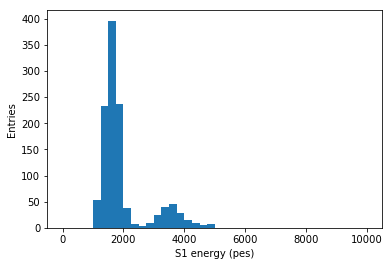

In [12]:
hist(srs.S1e, 40, (0,10000))
labels("S1 energy (pes)", "Entries")

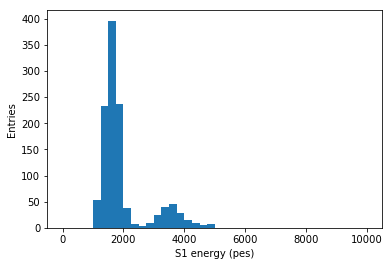

In [13]:
hist(srsc.S1e, 40, (0,10000))
labels("S1 energy (pes)", "Entries")

In [14]:
s1par  = S12Params(tmin=  0*units.mus, tmax=649*units.mus, lmin=5, lmax=30, stride=4, rebin=False)
s2par = S12Params( tmin=649*units.mus, tmax=700*units.mus, stride=80, lmin=80, lmax=20000, rebin=True)
thr    = ThresholdParams(thr_s1=3 * units.pes,  thr_s2=1*units.pes,
                        thr_MAU = 3 * units.adc, thr_sipm = .5 * units.pes,
                        thr_SIPM = 30 * units.adc)
epm = EventPmaps(run_number, s1par, s2par, thr, verbose=False)

In [15]:
MEVTS = 2000

Aswf = np.zeros((1792, 700,), dtype=np.float32)
Bswf = np.zeros((1792, 700,), dtype=np.float32)

Apes = []
Aext_pes = []
Aint_pes = []
At = []


Bpes = []
Bspes = []
Bfpes = []
Bt = []

Bext_pes = []
Bint_pes = []

pevts = 0
for subrun in RWF_files:
    if pevts == MEVTS: break
    h5rwf = tb.open_file(subrun,'r')
    pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
    NEVT, NPMT, PMTWL = pmtrwf.shape
    NEVT, NSIPM, SIPMWL = sipmrwf.shape
    print("""
            Number of events in file = {}
            Number of PMTs = {}
            PMTWL = {}
            Number of SiPMs = {}
            SiPMWL = {}
          """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))
    
    # Select desired waveforms
    assert(NEVT == h5rwf.root.Run.events[-1][0] - h5rwf.root.Run.events[0][0] + 1)
    ssev = h5rwf.root.Run.events[0][0]
    sfev = h5rwf.root.Run.events[-1][0]
    sr = srs[in_range(srs.event, ssev, sfev)]
    srevents = np.array(list(set(sr.event.values)))
    srinds = srevents - ssev
    spmtrwf = np.array(pmtrwf) [srinds]
    ssipmrwf= np.array(sipmrwf)[srinds]
    
    print('IC Alpha Candidates in this subrun: ', len(ssipmrwf))
    
    for evi in range(len(spmtrwf)):
        
        # Run IC
        epm.calibrated_pmt_and_csum(evi, spmtrwf)
        epm.calibrated_sipm(evi, ssipmrwf, calwf=True)
        epm.find_s1()
        epm.find_s2()
        epm.find_s2si()
        
        # Find A and B regions (ns)
        tbuf   t= 100 * units.ns
        Atimes = np.array([epm.S1[0][0][-1] + tbuf, epm.S2[0][0][0] - tbuf], dtype=np.float32)
        Ai     = np.array(np.ceil(Atimes / units.mus), dtype=np.int32)
        regA   = epm.sipm[:, Ai[0]: Ai[1]+1]
    
        Btimes = np.array([epm.S2[0][0][-1] + tbuf, 1300000         - tbuf], dtype=np.float32)
        Bi     = np.array(np.ceil(Btimes / units.mus), dtype=np.int32)
        regB   = epm.sipm[:, Bi[0]: Bi[1]+1]
        
        # Add A and B regions to Aswf and Bswf 
        Aswf[:, :regA.shape[1]] += regA
        Bswf[:, :regB.shape[1]] += regB
        
        # Record pes in these regions
        Apes.append(regA.sum(axis=1))
        Bpes.append(regB.sum(axis=1))
        
        # Compute pes in internal and external SiPMs
        At.append(regA.shape[1])                           # length in mus of reg
        Aext_pes_per_sipm = Apes[-1][ext_sipms].mean()     # pes per SiPM in ext sipms
        Aext_pes.append(Aext_pes_per_sipm)              
        Aint_pes.append(Apes[-1].sum() - Aext_pes_per_sipm) # pes per sipm in int sipms
        
        Bt.append(regB.shape[1])
        Bext_pes_per_sipm = Bpes[-1][ext_sipms].mean()
        Bext_pes.append(Bext_pes_per_sipm)
        Bint_pes.append(Bpes[-1].sum() - Bext_pes_per_sipm)
        Bspes.append(regB[:, :int(round(regB.shape[1] / 2.0))].sum()) # count pes in first half of regB
        Bfpes.append(np.sum(Bpes[-1]) - Bspes[-1])                        # in second half of regB
        pevts += 1
        if pevts == MEVTS: break
            
            
    h5rwf.close()
    #break

At   =np.array(At)   
Apes =np.array(Apes)
Bpes =np.array(Bpes)
Bspes=np.array(Bspes)
Bfpes=np.array(Bfpes)
Bt   =np.array(Bt)
Aext_pes = np.array(Aext_pes) / float(len(ext_sipms))
Aint_pes = np.array(Aint_pes) / (1792 - float(len(ext_sipms)))  
Bext_pes = np.array(Bext_pes) / float(len(ext_sipms))
Bint_pes = np.array(Bint_pes) / (1792 - float(len(ext_sipms)))   


            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
          
IC Alpha Candidates in this subrun:  116

            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
          
IC Alpha Candidates in this subrun:  98

            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
          
IC Alpha Candidates in this subrun:  120

            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
          
IC Alpha Candidates in this subrun:  117

            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
    

In [47]:
print('NEVTS processed: ', len(At))

NEVTS processed:  1145


#### PEs in region A vs region B

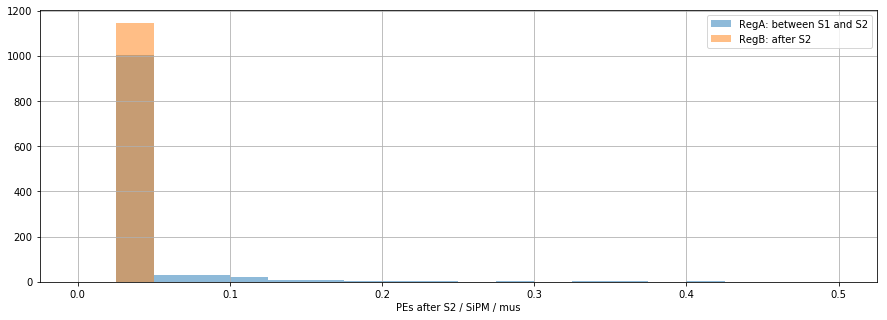

In [48]:
plt.figure(figsize=(15,5))
nza = np.nonzero(At)[0]
r=(0,.5)
plt.hist(Apes.mean(axis=1)[nza] / At[nza], bins = 20, alpha=.5, range=r, label='RegA: between S1 and S2')
plt.hist(Bpes.mean(axis=1)      / Bt     , bins = 20, alpha=.5, range=r, label='RegB: after S2')
plt.xlabel('PEs after S2 / SiPM / mus')
plt.legend()
plt.grid(True)
plt.show()

#### Cumulative waveform after S2

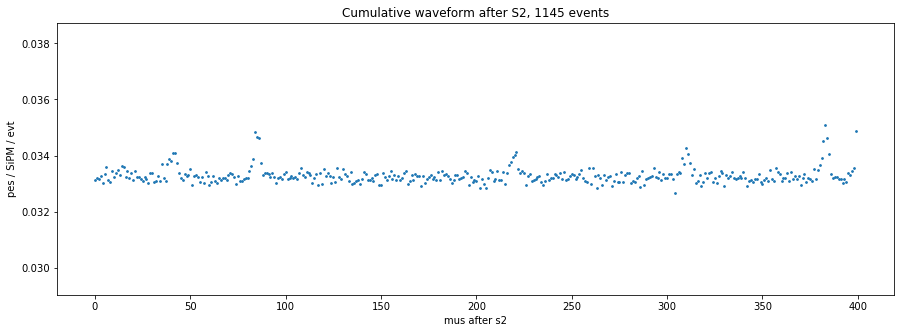

In [54]:
plt.figure(figsize=(15,5))
Bmeansum = Bswf.sum(axis=0)[100:500] / float(pevts)
plt.scatter(range(len(Bmeansum[np.nonzero(Bmeansum)])), Bmeansum[np.nonzero(Bmeansum)]/1792.0, s=3)
plt.title('Cumulative waveform after S2, ' + str(len(At)) + ' events')
plt.xlabel('mus after s2')
plt.ylabel('pes / SiPM / evt')
plt.show()

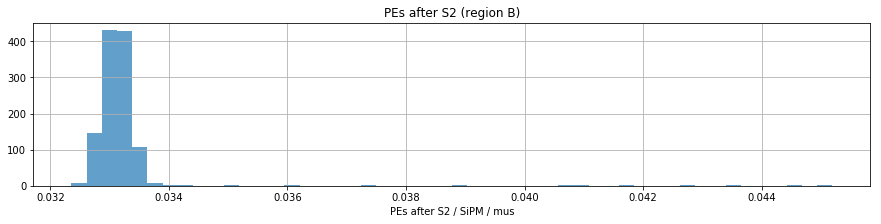

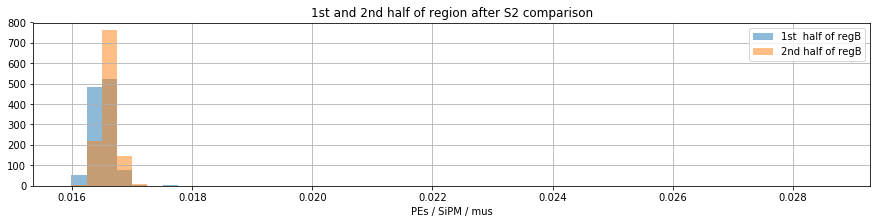

In [52]:
plt.figure(figsize=(15,3))
plt.hist(Bpes.mean(axis=1) / Bt, bins = 50, alpha=.7)
plt.title('PEs after S2 (region B)')
plt.xlabel('PEs after S2 / SiPM / mus')
plt.grid(True)
plt.show()

binmin = min((Bspes / Bt / 1792).min(), (Bfpes / Bt / 1792).min())
binmax = max((Bspes / Bt / 1792).max(), (Bfpes / Bt / 1792).max())
normed=False
plt.figure(figsize=(15,3))
plt.hist(Bspes / Bt / 1792, bins=50, normed=normed, range=(binmin, binmax), alpha=.5, label='1st  half of regB')
plt.hist(Bfpes / Bt / 1792, bins=50, normed=normed, range=(binmin, binmax), alpha=.5, label='2nd half of regB')
plt.grid(True)
plt.title('1st and 2nd half of region after S2 comparison')
plt.xlabel('PEs / SiPM / mus')
plt.legend()
plt.show()

Here external means sipms at R > 170.0


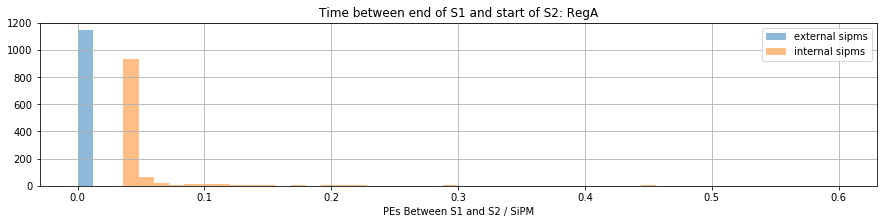

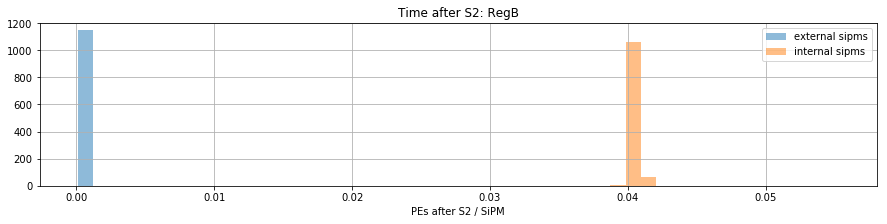

In [53]:
print('Here external means sipms at R >', ext_t)
binmin = min((Aint_pes[nza] / At[nza]).min(), (Aext_pes[nza] / At[nza]).min())
binmax = max((Aint_pes[nza] / At[nza]).max(), (Aext_pes[nza] / At[nza]).max())
binmax = 0.6
normed=False
plt.figure(figsize=(15,3))
plt.hist(Aext_pes[nza] / At[nza], bins=50, normed=normed, range=(binmin, binmax), alpha=.5, label='external sipms')
plt.hist(Aint_pes[nza] / At[nza], bins=50, normed=normed, range=(binmin, binmax), alpha=.5, label='internal sipms')
plt.grid(True)
plt.title('Time between end of S1 and start of S2: RegA')
plt.xlabel('PEs Between S1 and S2 / SiPM')
plt.legend()
plt.show()

binmin = min((Bext_pes / Bt).min(), (Bint_pes / Bt).min())
binmax = max((Bext_pes / Bt).max(), (Bint_pes / Bt).max())
normed=False
plt.figure(figsize=(15,3))
plt.hist(Bext_pes / Bt, bins=50, normed=normed, range=(binmin, binmax), alpha=.5, label='external sipms')
plt.hist(Bint_pes / Bt, bins=50, normed=normed, range=(binmin, binmax), alpha=.5, label='internal sipms')
plt.grid(True)
plt.title('Time after S2: RegB')
plt.xlabel('PEs after S2 / SiPM')
plt.legend()
plt.show()